In [1]:
import pandas as pd
import matplotlib.pyplot as plt                                # plotting
import numpy as np                                             # dense matrices
import json
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.preprocessing import normalize                    # normalizing vectors
from sklearn.metrics import pairwise_distances                 # pairwise distances
import sys      
import os
%matplotlib inline

#Load data, extract features
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']

    return csr_matrix( (data, indices, indptr), shape)

wiki = pd.read_csv('people_wiki.csv')
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')
with open('people_wiki_map_index_to_word.json') as file:    
    map_index_to_word = json.load(file)

#Normalize all vectors
tf_idf = normalize(tf_idf)    

In [2]:
#Implement k-means
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

#Assign each data point to the closest centroid
#Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]
#Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')
print(dist)

#initialize three centroids with the first 3 rows of tf_idf
test_queries = tf_idf[:3,:]
test_dist = pairwise_distances(tf_idf, test_queries, metric='euclidean')[430][1]
'''Test cell'''
if np.allclose(test_dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')
    
#Read the documentation and write code to produce a 1D array 
#whose i-th entry indicates the centroid that is the closest to the i-th data point   
distances = pairwise_distances(tf_idf, test_queries, metric='euclidean')
closest_cluster = np.argmin(distances, axis=1)
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

'''
First, initialize three centroids with the first 3 rows of tf_idf. 
Then, compute distances from each of the centroids to all data points in tf_idf. 
Finally, use these distance calculations to compute cluster assignments and 
assign them to cluster_assignment. 
'''

queries = tf_idf[:3,:]
distances = pairwise_distances(tf_idf, queries, metric='euclidean')
cluster_assignment = np.argmin(distances, axis=1)

if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

[[ 1.41000789  1.36894636]
 [ 1.40935215  1.41023886]
 [ 1.39855967  1.40890299]
 ..., 
 [ 1.41108296  1.39123646]
 [ 1.41022804  1.31468652]
 [ 1.39899784  1.41072448]]
Pass
Pass
Pass


In [3]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, 
                                                  centroids, 
                                                  metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment    
   
#Checkpoint
if np.allclose(assign_clusters(tf_idf[0:100:10], 
                               tf_idf[0:8:2]),
               np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


In [4]:
#Revise centroids as the mean of the assigned data points
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)   # prints [0 1 0]
#data points assigned to cluster 1
print(data[cluster_assignment==1])
#data points assigned to cluster 0
print(data[cluster_assignment==0])
#average the data points in cluster 0
print(data[cluster_assignment==0].mean(axis=0))

[0 1 0]
[[ 0.  0.  0.]]
[[ 1.  2.  0.]
 [ 2.  2.  0.]]
[ 1.5  2.   0. ]


In [5]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

#Checkpoint
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0)) and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


In [6]:
#Assess convergence
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity


In [7]:
#Combine into a single function
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment


0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

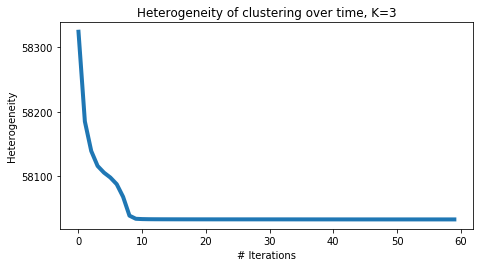

In [8]:
#Plot convergence metric
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)    
#The clustering objective (heterogeneity) is non-increasing for this example
#If the clustering objective (heterogeneity) would ever increase when running k-means, 
#that would indicate: Nothing is wrong. The objective should generally go down sooner or later


In [9]:
#Which of the cluster contains the greatest number of data points in the end
print(np.bincount(cluster_assignment)) #cluster 2

[19595 10427 29049]


In [10]:
#Beware of local minima
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)
#This indicates that k-means sometimes gets stuck at a bad local minimum

#Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. 
#Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. 
#How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes?
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    
    bin_array = np.bincount(cluster_assignment)
    idx = np.argmax(bin_array) 
    val = bin_array[idx]
    print('seed={}, max_idx:{}, max_val:{}'.format(seed, idx, val))
    idx = np.argmin(bin_array) 
    val = bin_array[idx]
    print('seed={}, min_idx:{}, min_val:{}'.format(seed, idx, val))    
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57457.52442
seed=020000, heterogeneity=57533.20100
seed=040000, heterogeneity=57512.69257
seed=060000, heterogeneity=57466.97925
seed=080000, heterogeneity=57494.92990
seed=100000, heterogeneity=57484.42210
seed=120000, heterogeneity=57554.62410
366.80706334114075
seed=0, max_idx:0, max_val:18047
seed=0, min_idx:4, min_val:1492
seed=000000, heterogeneity=57457.52442
seed=20000, max_idx:4, max_val:15779
seed=20000, min_idx:1, min_val:768
seed=020000, heterogeneity=57533.20100
seed=40000, max_idx:9, max_val:18132
seed=40000, min_idx:2, min_val:186
seed=040000, heterogeneity=57512.69257
seed=60000, max_idx:9, max_val:17900
seed=60000, min_idx:7, min_val:424
seed=060000, heterogeneity=57466.97925
seed=80000, max_idx:0, max_val:17582
seed=80000, min_idx:5, min_val:809
seed=080000, heterogeneity=57494.92990
seed=100000, max_idx:4, max_val:16969
seed=100000, min_idx:1, min_val:1337
seed=100000, heterogeneity=57484.42210
seed=120000, max_idx:6, max_val:16481
seed=120

In [11]:
#One effective way to counter this tendency is to use k-means++ to provide a smart initialization. 
#This method tries to spread out the initial set of centroids so that they are not too close together. 
#It is known to improve the quality of local optima and lower average runtime.
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

#rerun k-means with 10 clusters using the same set of seeds, 
#using k-means++ to initialize the algorithm
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, 
                                                      cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839
429.99395513534546


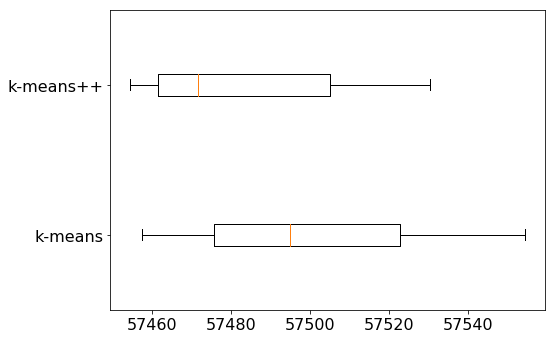

In [12]:
#compare the set of cluster heterogeneities from 7 restarts of k-means 
#using random initialization vs using k-means++ as a smart initialization
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), 
             list(heterogeneity_smart.values())],
            vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
#On average, k-means++ produces a better clustering than Random initialization
#Variation in clustering quality is smaller for k-means++

In [13]:
#In general, run k-means at least a few times with different initializations 
#return the run resulting in the lowest heterogeneity
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, 
                                               maxiter, 
                                               record_heterogeneity=None, 
                                               verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, 
                                                    cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

2
10
25
50
100


'\nIn the above plot we show that heterogeneity goes down as we increase the number of clusters. \nDoes this mean we should always favor a higher K? Not at all! \nAs we will see in the following section, \nsetting K too high may end up separating data points that are actually pretty alike. \nAt the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, \nbut separating each data point into its own cluster is hardly a desirable outcome. \nIn the following section, we will learn how to detect a K set "too large".\n'

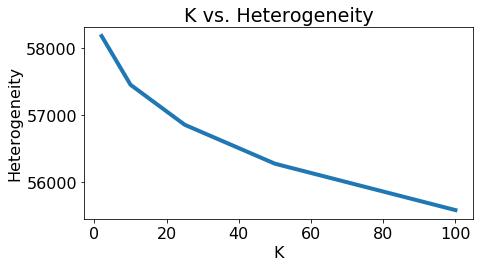

In [88]:
#How to choose K

#Use the kmeans_multiple_runs function to run k-means with five different values of K. 
#For each K, use k-means++ and multiple runs to pick the best solution. 
#In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting

#def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
#    plt.figure(figsize=(7,4))
#    plt.plot(k_values, heterogeneity_values, linewidth=4)
#    plt.xlabel('K')
#    plt.ylabel('Heterogeneity')
#    plt.title('K vs. Heterogeneity')
#    plt.rcParams.update({'font.size': 16})
#    plt.tight_layout()

#start = time.time()
#centroids = {}
#cluster_assignment = {}
#heterogeneity_values = []
#k_list = [2, 10, 25, 50, 100]
#seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

#for k in k_list:
#    heterogeneity = []
#    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
#                                                               num_runs=len(seed_list),
#                                                               seed_list=seed_list,
#                                                               verbose=True)
#    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
#    heterogeneity_values.append(score)

#plot_k_vs_heterogeneity(k_list, heterogeneity_values)

#end = time.time()
#print(end-start)

def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz' #pre-computed array

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print(k)
        sys.stdout.flush()
        
        '''
        centroids[k] = arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = arrays['cluster_assignment_{0:d}'.format(k)]
        '''
        
        '''To save memory space, do not load the arrays from the file right away.
           Use a technique known as lazy evaluation, 
           where some expressions are not evaluated until later. 
           Any expression appearing inside a lambda function doesn't get evaluated 
           until the function is called. Lazy evaluation is extremely important 
           in memory-constrained setting, such as an Amazon EC2 t2.micro instance.'''
        #load in file in this way so that later visualize_document_clusters can work
        
        centroids[k] = lambda k=k: arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = lambda k=k: arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k](), cluster_assignment[k]())
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')
    
'''
In the above plot we show that heterogeneity goes down as we increase the number of clusters. 
Does this mean we should always favor a higher K? Not at all! 
As we will see in the following section, 
setting K too high may end up separating data points that are actually pretty alike. 
At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, 
but separating each data point into its own cluster is hardly a desirable outcome. 
In the following section, we will learn how to detect a K set "too large".
'''    

In [69]:
with open('people_wiki_map_index_to_word.json') as file:    
    map_index_to_word = json.load(file) #word: index -> key: value

map_index_to_word = pd.DataFrame(list(map_index_to_word.items()), columns=['category', 'index'])    
#dict.items() return pairs in tuples 
#in order to make those work in pd.DataFrame(), they have to be casted as a list()

In [77]:
map_index_to_word.head(3)

,category,index
0,biennials,522004
1,lb915,116290
2,shatzky,127647


In [84]:
#Visualize clusters of documents
'''
in a good clustering of documents:
Documents in the same cluster should be similar.
Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
Documents in a cluster have mixed content.
Documents with similar content are divided up and put into different clusters
'''
#Fetch nearest neighbors of each centroid from the set of documents assigned to 
#that cluster as being representative of the cluster.
#Print titles and first sentences of those nearest neighbors.
#Print top 5 words that have highest tf-idf weights in each centroid.

def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word['category'][idx[i]], centroids[c,idx[i]])), 
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.iloc[nearest_neighbors[i]]['name'],
                      distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [90]:
#another way of implementation
with open('people_wiki_map_index_to_word.json') as file:    
    map_index_to_word = json.load(file) #word: index -> key: value
#invert the dict mapping using dict comperhention
map_index_to_word = {v:k for k,v in map_index_to_word.items()} 
#index: word -> key: value

def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word[idx[i]], centroids[c,idx[i]])), #there is no 'category'
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.iloc[nearest_neighbors[i]]['name'],
                      distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [91]:
#2 cluster case (K=2)
'''
The way read kmeans_arrays.npz matters. Replace script suggested with lazy evaluation
'''
visualize_document_clusters(wiki, tf_idf, centroids[2](), cluster_assignment[2](), 2, map_index_to_word)
'''
Cluster 0: artists, songwriters, professors, politicians, writers, etc.
Cluster 1: baseball players, hockey players, soccer (association football) players, etc.
Top words of cluster 1 are all related to sports, 
whereas top words of cluster 0 show no clear pattern.

Roughly speaking, the entire dataset was divided into athletes and non-athletes. 
It would be better if we sub-divided non-athletes into more categories. 
'''

Cluster 0    
she:0.025
her:0.017
music:0.012
he:0.011
university:0.011


* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda                         

'\nThe way read kmeans_arrays.npz matters. Replace script suggested with \n'

In [98]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k, map_index_to_word)
'''
Clusters are now more pure, but some are qualitatively "bigger" than others. 
For instance, the category of scholars is more general than the category of baseball players. 
Increasing the number of clusters may split larger clusters. 
Another way to look at the size of cluster is to count the number of articles in each cluster
'''

Cluster 0    
film:0.020
art:0.014
he:0.011
book:0.010
television:0.010


* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                                        0.97823
  paul swadel is a new

football:0.076
coach:0.060
basketball:0.056
season:0.044
played:0.037


* Todd Curley                                        0.92731
  todd curley born 14 january 1973 is a former australian rules footballer who played for co
  llingwood and the western bulldogs in the australian football league

* Ashley Prescott                                    0.92992
  ashley prescott born 11 september 1972 is a former australian rules footballer he played w
  ith the richmond and fremantle football clubs in the afl between

* Pete Richardson                                    0.93204
  pete richardson born october 17 1946 in youngstown ohio is a former american football defe
  nsive back in the national football league and former college head

* Nathan Brown (Australian footballer born 1976)     0.93561
  nathan daniel brown born 14 august 1976 is an australian rules footballer who played for t
  he melbourne demons in the australian football leaguehe was drafted

* Earl Spalding                

'\nClusters are now more pure, but some are qualitatively "bigger" than others. \nFor instance, the category of scholars is more general than the category of baseball players. \nIncreasing the number of clusters may split larger clusters. \nAnother way to look at the size of cluster is to count the number of articles in each cluster\n'

In [97]:
np.bincount(cluster_assignment[10]())
#Cluster 0: artists, actors, film directors, playwrights
#of the 10 clusters above contains the greatest number of articles
#Cluster 8: ice hockey players
#of the 10 clusters contains the least number of articles

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,  8926], dtype=int64)

In [102]:
#k = 25 & turn off text for brevity
#visualize_document_clusters(wiki, tf_idf, centroids[25](), cluster_assignment[25](), 
#                            25, map_index_to_word, display_content=False) 

visualize_document_clusters(wiki, tf_idf, centroids[25](), cluster_assignment[25](), 
                            25, map_index_to_word, display_content=True) 

Cluster 0    
law:0.077
district:0.048
court:0.046
republican:0.038
senate:0.038


* George B. Daniels                                  0.92779
  george benjamin daniels born 1953 is a united states federal judge for the united states d
  istrict court for the southern district of new yorkdaniels was

* William G. Young                                   0.92867
  william glover young born 1940 is a united states federal judge for the district of massac
  husetts young was born in huntington new york he attended

* Jean Constance Hamilton                            0.92969
  jean constance hamilton born 1945 is a senior united states district judge of the united s
  tates district court for the eastern district of missouriborn in

* Barry Sullivan (lawyer)                            0.92991
  barry sullivan is a chicago lawyer and as of july 1 2009 the cooney conway chair in advoca
  cy at loyola university chicago school of law

* James G. Carr                                      0.93


* Snyder Rini                                        0.89987
  snyder rini born 27 july 1949 is a solomon islands politician who was briefly the eighth p
  rime minister of the solomon islands from april to

* William Haomae                                     0.90011
  william nii haomaepia born november 26 1960 is a politician of the solomon islands who has
   been minister for foreign affairs and external trade since

* Mohlabi Tsekoa                                     0.90660
  mohlabi kenneth tsekoa born 13 august 1945 is the minister of foreign affairs of lesotho h
  e has served in the cabinet since july 2001 first

* Monique Landry                                     0.90707
  monique landry pc born december 25 1937 is a former canadian politician a physiotherapist 
  and administrator she was first elected to the canadian house of

* Carmel Zollo                                       0.90722
  carmelina carmel zollo born 10 january 1952 is an australian politician and an aus


* Lauren Royal                                       0.93302
  lauren royal born march 3 circa 1965 is a book writer from california royal has written bo
  th historic and novelistic booksa selfproclaimed angels baseball fan

* Barbara Hershey                                    0.93323
  barbara hershey born barbara lynn herzstein february 5 1948 once known as barbara seagull 
  is an american actress in a career spanning nearly 50 years

* Janet Jackson                                      0.93449
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Janine Shepherd                                    0.93640
  janine lee shepherd am born 1962 is an australian pilot and former crosscountry skier shep
  herds career as an athlete ended when she suffered major injuries

* Jane Fonda                                         0.93642
  jane fonda born lady jayne seymour fonda december 2


* David J. Elliott                                   0.93913
  david elliott is professor of music and music education at new york universityelliott was 
  educated at the university of toronto bmus m mus and bed

* Marc Hoffman                                       0.94194
  marc hoffman born april 16 1961 is a composer of concert music and music for film pianist 
  vocalist recording artist and music educator hoffman grew

* Frederique Trunk                                   0.94316
  frederique trunk was born in colmar france and graduated in 1986 from the conservatoire de
   music de strasbourg with honors in piano ear training and

* Tom Bancroft                                       0.94385
  tom bancroft born 1967 london is a british jazz drummer and composer he began drumming age
  d seven and started off playing jazz with his father

* Andrew Bain (drummer)                              0.94485
  andrew bain was born in edinburgh scotland and began studying percussion and drum


* William Y. Smith                                   0.90325
  general william young smith born august 1314 1925 is a retired united states air force fou
  rstar general who served as chief of staff supreme headquarters

* Neil D. Van Sickle                                 0.90636
  neil david van sickle born july 8 1915 is a retired american air force major general who w
  as the deputy inspector general at headquarters united

* Freddie L. Poston                                  0.91147
  freddie lee poston born september 16 1925 was an american lieutenant general who was chief
   of staff united states pacific command camp h m smith

* James R. Brown                                     0.91221
  james robert brown born june 17 1930 was a lieutenant general in the united states air for
  ce who served as vice commander of tactical air

* Craven C. Rogers Jr.                               0.91251
  craven c rogers jr born september 16 1934 was a lieutenant general in the united state

In [103]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), 
                            k, map_index_to_word, display_content=False)

#The class of soccer (association football) players has been broken into two clusters (44 and 45). 
#Same goes for Austrialian rules football players (clusters 26 and 48). 
#The class of baseball players have been also broken into two clusters (16 and 91).

'''
A high value of K encourages pure clusters, but we cannot keep increasing K. 
For large enough K, related documents end up going to different clusters.
'''
#That said, the result for K=100 is not entirely bad. 
#After all, it gives us separate clusters for such categories as Brazil, wrestling, computer science and the Mormon Church. 
#If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.
#Also, we should ask ourselves how much granularity we want in our clustering. 
#If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. 
#On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.
'''
There is no golden rule for choosing K. 
It all depends on the particular application and domain we are in.
'''
#Another heuristic people use that does not rely on so much visualization, 
#which can be hard in many applications (including here!) is as follows. 
#Track heterogeneity versus K and look for the "elbow" of the curve 
#where the heterogeneity decrease rapidly before this value of K, 
#but then only gradually for larger values of K. 
#This naturally trades off between trying to minimize heterogeneity, but reduce model complexity. 
#In the heterogeneity versus K plot made above, we did not yet really see a flattening out of the heterogeneity, 
#which might indicate that indeed K=100 is "reasonable" and we only see real overfitting for larger values of K 
#(which are even harder to visualize using the methods we attempted above.)

Cluster 0    
brazilian:0.137
brazil:0.082
de:0.056
rio:0.053
paulo:0.050

Cluster 1    
bishop:0.170
diocese:0.085
archbishop:0.083
church:0.072
ordained:0.058

Cluster 2    
zealand:0.247
new:0.069
auckland:0.056
wellington:0.031
zealands:0.029

Cluster 3    
comics:0.181
comic:0.121
strip:0.042
graphic:0.036
book:0.034

Cluster 4    
puerto:0.309
rico:0.220
rican:0.066
juan:0.041
ricos:0.031

Cluster 5    
bbc:0.192
radio:0.127
presenter:0.054
show:0.046
news:0.042

Cluster 6    
senate:0.059
district:0.053
county:0.051
committee:0.049
state:0.044

Cluster 7    
labor:0.105
australian:0.099
liberal:0.071
election:0.067
seat:0.061

Cluster 8    
economics:0.065
university:0.048
research:0.045
professor:0.043
economic:0.043

Cluster 9    
foreign:0.086
ambassador:0.076
affairs:0.061
nations:0.053
united:0.040

Cluster 10    
she:0.188
her:0.052
women:0.026
womens:0.020
council:0.019

Cluster 11    
rowing:0.246
sculls:0.097
rower:0.081
olympics:0.073
championships:0.068

Cluster 12   

jewish:0.193
rabbi:0.132
israel:0.052
hebrew:0.038
jews:0.032

Cluster 62    
ballet:0.362
dance:0.109
dancer:0.084
she:0.057
danced:0.044

Cluster 63    
hockey:0.220
nhl:0.138
ice:0.067
season:0.053
league:0.048

Cluster 64    
law:0.148
court:0.093
judge:0.071
district:0.051
justice:0.043

Cluster 65    
coach:0.205
head:0.086
basketball:0.059
coaching:0.052
football:0.046

Cluster 66    
armenian:0.278
armenia:0.168
yerevan:0.100
sargsyan:0.055
genocide:0.031

Cluster 67    
album:0.088
released:0.044
music:0.040
records:0.033
albums:0.027

Cluster 68    
she:0.158
her:0.152
music:0.020
album:0.016
singer:0.013

Cluster 69    
theatre:0.194
directed:0.034
production:0.031
play:0.029
actor:0.027

Cluster 70    
health:0.099
medical:0.089
medicine:0.086
research:0.039
clinical:0.039

Cluster 71    
european:0.145
parliament:0.115
party:0.053
member:0.049
committee:0.048

Cluster 72    
marathon:0.459
half:0.087
she:0.082
hours:0.063
championships:0.062

Cluster 73    
she:0.147
her:0

'\nThere is no golden rule for choosing K. \nIt all depends on the particular application and domain we are in.\n'

In [104]:
'''
Another sign of too large K is having lots of small clusters. 
Look at the distribution of cluster sizes (by number of member data points)
'''
sum(np.bincount(cluster_assignment[100]()) < 236)
#29 of the 100 clusters have fewer than 236 articles, i.e. 0.4% of the dataset
#Keep in mind though that tiny clusters aren't necessarily bad. 
#A tiny cluster of documents that really look like each others is definitely preferable 
#to a medium-sized cluster of documents with mixed content. 
#However, having too few articles in a cluster may cause overfitting 
#by reading too much into limited pool of training data.

29